# Make a FisherMatrix object that was only limited by l_max also have a k_max limit

In [1]:
import crosspower as cp
import FisherCl as fcl # branch quickCl
#import noiseCl as ncl
#import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

IMPORT ERROR: /opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/quicklens/mpi.pyc (No module named pypar). Could not load pbs or pypar. MPI will not be used.


# Load two k,g + T,E Fisher Objects with noise

In [2]:
# Load saved Fobj2, Fobj4
# The suffix 2 is for nonlinear, suffix 4 is for linear (just to keep with the established pattern)

import FisherCl as fcl
import noiseCl as ncl
import crosspower as cp
import pickle

filehandler2 = open('Fisher_7_6A.obj','r') # AccuracyBoost=3, lmax=3000, lmaxP=5000, nz=3e5; nonlinear=True,
#neutrino_hierarchy = 'normal', usePrimaryCMB = True; from FisherCl branch quickCl
# kludge for this one: told cp.getDNDZinterp to use modelDNDZ3; set cp.tophat beesBins=True
# biasByBin = False (uses sigma(b)/b), dw = 0.05, useNoise = True
# apparently this one had way too much shot noise - need to re-make it with fixed code

#filehandler2 = open('Fisher_7_6X2_w2_wan.obj','r') # AccuracyBoost=3, lmax=3000, lmaxP=5000, nz=3e5; nonlinear=True,
filehandler4 = open('Fisher_7_6X4_w2_wan.obj','r') # AccuracyBoost=3, lmax=3000, lmaxP=5000, nz=3e5; nonlinear=False,

Fobj2 = pickle.load(filehandler2) 
Fobj4 = pickle.load(filehandler4) 


lmin = Fobj2.lmin
lmax = Fobj2.lmax
nBins = Fobj2.nBins
nMaps = Fobj2.nBins + 1
nParams = Fobj2.nParams
nCosParams = Fobj2.nParams - Fobj2.nBins
ells = Fobj2.ells
obsNames = Fobj2.obsNames
paramList = Fobj2.paramList

print Fobj2.obsList
print Fobj2.obsNames
print Fobj2.paramList

print Fobj2.Fij.shape
print Fobj2.FijTE.shape
print Fobj2.nParams
print Fobj2.nCosParams



[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 16. 17. 18. 19. 20.
 24. 25. 26. 27. 32. 33. 34. 40. 41. 48.]
['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'k,g5', 'k,g6', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g1,g5', 'g1,g6', 'g2,g2', 'g2,g3', 'g2,g4', 'g2,g5', 'g2,g6', 'g3,g3', 'g3,g4', 'g3,g5', 'g3,g6', 'g4,g4', 'g4,g5', 'g4,g6', 'g5,g5', 'g5,g6', 'g6,g6']
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'wa', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']
(15, 15)
(9, 9)
15
9


In [3]:
# test shot noise generator
#newNoise = True
newNoise = False
if newNoise:
    import noiseCl as ncl
    reload(ncl)

    nbar = 66
    binEdges = binEdges = [0.0,0.5,1.0,2.0,3.0,4.0,7.0]
    #binEdges = np.linspace(Fobj2.zmin,Fobj2.zmax,Fobj2.nBins+1)
    N_gg = ncl.shotNoise(nbar,binEdges,myDNDZ=cp.modelDNDZ3,nz=100000,verbose=False)
    print N_gg


In [4]:
# adjust noise in Fobj2
if newNoise:
    for binNum in range(Fobj2.nBins):
        Fobj2.noiseCls[binNum+1,binNum+1] = N_gg[binNum]*np.ones(Fobj2.lmax-Fobj2.lmin+1)
        # or try with zero noise:
        #Fobj2.noiseCls[binNum+1,binNum+1] = N_gg[binNum]*np.zeros(Fobj2.lmax-Fobj2.lmin+1)
        # or try scaling by b**-1:
        #Fobj2.noiseCls[binNum+1,binNum+1] = N_gg[binNum]*np.ones(Fobj2.lmax-Fobj2.lmin+1)/Fobj2.binBs[binNum]
    Fobj2.covar,Fobj2.invCov,Fobj2.ells,Fobj2.obsList = \
        Fobj2.makeCovar(Fobj2.crossCls,Fobj2.noiseCls,Fobj2.lmin,Fobj2.lmax)
    Fobj2.Fij = Fobj2.makeFisher(Fobj2.lmin)
    print 'done.'

In [5]:
for i in range(1,7):
    print Fobj2.noiseCls[i][i][0]


0.024206479664841445
0.04872266115456238
0.27623302447473885
2.0738527158240956
17.83176396456695
166.36826370533282


# Create $\chi(z)$ and $\ell_{max}(k_{max})$ functions

In [7]:
# MatterPower has a getChiOfZ function, but MatterPower object has been stripped from saved Fobj
# get params for MatterPower from FisherMatrix:
def getPk(Fobj):
    return cp.MatterPower(nz=Fobj.nz,AccuracyBoost=Fobj.AccuracyBoost,nonlinear=Fobj.nonlinear,**Fobj.cosParams)

print 'get nonlinear P(k)...'
myPk2 = getPk(Fobj2)
print 'get linear P(k)...'
myPk4 = getPk(Fobj4)

chiOfZ2 = myPk2.getChiofZ()
chiOfZ4 = myPk4.getChiofZ()

# define bin edges
# the selection of beesBins must be consistent with that which was selected in cp.tophat
beesBins = True
if beesBins:
    if Fobj2.nBins == 6:
      binEdges = [0.0,0.5,1.0,2.0,3.0,4.0,7.0]
    elif Fobj2.nBins == 16:
      binEdges = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 
                  2.3, 2.6, 3.0, 3.5, 4.0, 7.0]
    else:
      print '!!!!! wrong nBins for beesBins detected !!!!!'
      #return 0
else:
    binEdges = np.linspace(Fobj.zmin,Fobj.zmax,Fobj.nBins+1)

print 'redshift of bin edges: ',binEdges
print 'Chi of bin edges (nonlin): ',chiOfZ2(binEdges)
print 'Chi of bin edges (linear): ',chiOfZ4(binEdges)

get nonlinear P(k)...
neutrino_hierarchy =  normal
starting makePkInterp.


finishing makePkInterp.
get linear P(k)...
neutrino_hierarchy =  normal
starting makePkInterp.
finishing makePkInterp.
redshift of bin edges:  [0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 7.0]
Chi of bin edges (nonlin):  [   0.         1950.44919184 3401.79011296 5316.35644135 6513.17408877
 7341.61486127 8822.44869176]
Chi of bin edges (linear):  [   0.         1950.44919184 3401.79011296 5316.35644135 6513.17408877
 7341.61486127 8822.44869176]


In [8]:
# lmax(kmax) function moved to within getKlimited function below

# Break apart covar and dClVecs as observables drop out

In [9]:
# set the kmax values used throughout

#kmax1 = 0.05  # don't go below this or bin 2 will have less than 50 ells and crash program
#kmax2 = 0.075

kmax1 = 0.1
kmax2 = 0.2

#kmax1 = 1.0
#kmax2 = 2.0  # no need to go above this since it is high enough to only kill bin1


In [10]:
# some helper functions for getKlimited, getKZlimited

# define row,col deleting function
def fixParam(Fij,pNum):
    return np.delete(np.delete(Fij,pNum,0),pNum,1)

# define the covar cutting function
def covarCut(covar,dClVecs,preMask,cutNum,verbose=True):
    """
    Purpose:
        produce covar and dClVecs with fewer observables
    Inputs:
        covar,dClVecs: like in Fobj
        preMask: this is a 1d array of binNumbers, 
          indicating which is the lowest bin number used for each row, col of covar 
          and each dClVec
        cutNum: a number contained in preMask indicating which rows, cols of covar, dClVecs to cut
    Returns:
        cut versions of covar,dClVecs,preMask
    """
    #toCut = np.flip(np.where(preMask[0]==cutNum),1)
    toCut = np.flip(np.where(preMask==cutNum),1) # removed 2nd dim of preMask since not needed
    if verbose:
        print 'to cut: ',toCut
    for cut in toCut:
        covar = fixParam(covar,cut)
        #preMask = fixParam(preMask,cut)
        preMask = np.delete(preMask,cut,0)
        dClVecs = np.delete(dClVecs,cut,0)
    if verbose:
        print 'covar.shape: ',covar.shape,', dClVecs.shape: ',dClVecs.shape
        print 'premask: ',preMask
    return covar,dClVecs,preMask


In [11]:
# check effect of dropping bin 1
# first define local makeFisher function
# (copied from below; don't really need both.)
def makeFij(dClVecs,invCov,nParams):
    """
    This may replace the previous makeFisher function... blah blah blah.
    Inputs:
        all must have same ell range.  All ell values will be summed over.
    """
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      dClVec_i = dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = dClVecs[:,j,:] # shape (nCls,nElls)
        # here is the summation over ell:
        for ellInd in range(invCov.shape[2]):
          #print dClVec_i.shape,invCov.shape,dClVec_j.shape
          fij = np.dot(dClVec_i[:,ellInd],np.dot(invCov[:,:,ellInd],dClVec_j[:,ellInd]))
          #if ellInd == 100:
            #print 'i,j: ',i,j
            #print 'f_ij: ',fij
            #print 'dClVec_i: ',dClVec_i[:,ellInd]
            #print 'invCov: ',invCov[:,:,ellInd]
            #print 'dClVec_j: ',dClVec_j[:,ellInd]
          Fij[i,j] += fij
    return Fij


In [12]:
# get pieces of Fobj2 for making Fij
dClVecs2 = Fobj2.dClVecs
covar2 = Fobj2.covar

invCov2 = np.transpose(np.linalg.inv(np.transpose(covar2)))
myLmin = 30
#myLmin = 50
#myLmin = 70
lmin = Fobj2.lmin #2
myLmax = 2000
print dClVecs2.shape
print invCov2.shape

(28, 15, 2999)
(28, 28, 2999)


In [13]:
# trim the bottom and get Fij
dClVecs50 = dClVecs2[:,:,myLmin-lmin:myLmax-lmin]
invCov50 = invCov2[:,:,myLmin-lmin:myLmax-lmin]
Fij50 = makeFij(dClVecs50,invCov50,Fobj2.nParams)

In [14]:
# this function also doubled from below
def getSigmas(Fij):
    #print np.diag(np.linalg.inv(Fij))
    return np.sqrt(np.diag(np.linalg.inv(Fij)))
 
sigmas50 = getSigmas(Fij50)

In [15]:
# excise bin 1 and repeat Fij, sigmas calc.
#print Fobj.obsList
nMaps = Fobj2.nBins + 1
map1List = np.floor(Fobj2.obsList/nMaps)
map2List = Fobj2.obsList%nMaps
print 'map i numbers: ',map1List
print 'map j numbers: ',map2List

map i numbers:  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 4. 4.
 4. 5. 5. 6.]
map j numbers:  [0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 3. 4. 5. 6. 4. 5.
 6. 5. 6. 6.]


In [16]:
whereOnes = [12,11,10,9,8,7,1]
preMaskOne = np.zeros((28))
preMaskOne[whereOnes] = 1
print preMaskOne
print map1List[whereOnes]
print map2List[whereOnes]
toCut = 1
covarOne,dClVecsOne,preMaskOne = covarCut(covar2.copy(),dClVecs2.copy(),preMaskOne,toCut)
print 'done.'

[0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 0.]
[6. 5. 4. 3. 2. 1. 1.]
to cut:  [[12 11 10  9  8  7  1]]
covar.shape:  (21, 21, 2999) , dClVecs.shape:  (21, 15, 2999)
premask:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
done.


In [17]:
invCovOne = np.transpose(np.linalg.inv(np.transpose(covarOne)))
dClVecs50B = dClVecsOne[:,:,myLmin-lmin:myLmax-lmin]
invCov50B = invCovOne[:,:,myLmin-lmin:myLmax-lmin]
Fij50B = makeFij(dClVecs50B,invCov50B,Fobj2.nParams)

In [18]:
print Fij50B[:,9]
# again, copied from below
def fixParam(Fij,pNum):
        return np.delete(np.delete(Fij,pNum,0),pNum,1)
Fij50B = fixParam(Fij50B,9)
sigmas50B = getSigmas(Fij50B)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
from prettytable import PrettyTable

print 'with bin1, and without bin1'
t = PrettyTable(['Parameter','sigmas_yes_bin1','sigmas_no_bin1','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas50[i]
    Bi = sigmas50B[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t


with bin1, and without bin1
+---------------+-----------------+----------------+---------------+
|   Parameter   | sigmas_yes_bin1 | sigmas_no_bin1 | percent diff. |
+---------------+-----------------+----------------+---------------+
|     ombh2     |      0.0239     |     0.0247     |       3.3     |
|     omch2     |      0.0782     |     0.0827     |      5.82     |
| cosmomc_theta |     0.00132     |    0.00132     |     0.356     |
|       As      |     1.39e-09    |    1.52e-09    |      9.02     |
|       ns      |      0.357      |     0.373      |      4.46     |
|      tau      |        384      |       442      |      14.9     |
|      mnu      |       1.02      |      1.12      |      9.71     |
|       w       |       13.2      |      18.3      |        39     |
|       wa      |       34.4      |      47.7      |      38.5     |
+---------------+-----------------+----------------+---------------+


In [20]:
# ok, that increased uncertainties, as expected.
# Also, sigmas_no_bin1 is the same result as with ketKlimited(kmax=5), which also just excises bin1.

In [61]:
# define function for creating blocks for making Fij
def getKlimited(binEdges,chiOfZ,Fobj,kmax=0.1,kgLmax=2000):
    """
    Purpose:
        Chop up Fobj.covar and Fobj.dClVecs into blocks that correspond to having ell values
          below ell(k_max,low_z_bin_edge) in Limber approximation
    Inputs:
        binEdges: an array of redshifts indicating the edges of the redshift bins
        chiOfZ: a distance-redshift relation function chi(z)
        Fobj: FisherMatrix object
        kmax: set the limit that controls the lmax of each redshift bin via Limber appx
          default: 0.1
        kgLmax: ell_max value for k,g
          default: 2000
    Returns:
        covarBins,dClVecsBins: lists of covar and dClVecs arrays to be used for making Fisher matrix
        lmaxByBin: the ell_max for each bin edge
        preMaskBins: list of one dimensional masks containing minimum bin numbers for covarBins,dClVecsBins
    """
    # create lmax function via the Limber approximation
    myLmax = lambda kmax: np.floor(kmax*chiOfZ(binEdges)-0.5).astype(int)
    lmaxByBin = myLmax(kmax) # gives array of lmax at lower bin edges
    # the -1 is from the -0.5 in the Limber approximation put into the floor function

    # modify this for use in looping below
    lmin = Fobj.lmin
    lmaxByBin[0] = Fobj.lmin
    if lmaxByBin[-1] < kgLmax:
        lmaxByBin[-1] = kgLmax
    print 'kmax = ',kmax,': lmax = ',lmaxByBin
    
    # get codes describing observables
    nBins = Fobj.nBins
    nMaps = Fobj.nBins+1
    print 'obs names: ',Fobj.obsNames
    #print Fobj.obsList
    map1List = np.floor(Fobj.obsList/nMaps)
    map2List = Fobj.obsList%nMaps
    print 'map i numbers: ',map1List
    print 'map j numbers: ',map2List

    print 'invCov shape: ',Fobj.invCov.shape, 'number of observables: ',Fobj.obsList.shape[0]
    print 'lmin, lmax for k,g summation: ',lmin,kgLmax

    # create mask for covariance matrix to be applied to implement lmax
    mSize = Fobj.obsList.__len__()
    preMask = np.zeros((mSize,mSize)) # contains lowest bin number (>0) of 4 used in covar
    print 'preMask shape: ',preMask.shape
    for i in range(mSize):
        for j in range(i,mSize):
            myMaps = np.array([map1List[i],map1List[j],map2List[i],map2List[j]])        
            if i>0 or j>0:
                preMask[i,j] = np.min(myMaps[np.where(myMaps>0)])
                preMask[j,i] = preMask[i,j]
            else:
                preMask[0,0] = 0
            #print i,j,myMaps, myMaps[np.where(myMaps>0)], preMask[i,j]
    preMask = preMask.astype(int)
    print preMask[0]
    
    covar=Fobj.covar
    dClVecs=Fobj.dClVecs
    print 'covar shape: ',covar.shape
    print 'dClVecs shape: ',dClVecs.shape
        
    # cut out all covar,dClVecs,preMask elements with row/col of 1s below lmaxByBin[0] = -1 : so all the way to lmin.

    # prepare containers for the results
    covarBins = []
    dClVecsBins = []
    preMaskBins = []

    # iterate as bins are removed
    verbose = True
    myEllMin = lmaxByBin[0]
    myEllMax = lmaxByBin[1]
    lastBlock = False # for stopping iteration if myEllMax is below kgLmax
    preMaskLine = preMask[0] # modified to use just the first line
    for binNum in range(nBins):
        print '\nstarting binNum {0} of {1}...'.format(binNum+1,nBins)
        covar,dClVecs,preMaskLine = covarCut(covar,dClVecs,preMaskLine,binNum+1,verbose=verbose)

        if lmaxByBin[binNum+1] < kgLmax:
            myEllMin = lmaxByBin[binNum]
            myEllMax = lmaxByBin[binNum+1]
        else:
            if lmaxByBin[binNum] < kgLmax:
                # prob. don't need this if here since only one endpoint will pass kgLmax then end the for loop
                myEllMin = lmaxByBin[binNum]
            myEllMax = kgLmax
            lastBlock = True
            
        covarBins.append( covar[:,:,myEllMin-lmin:myEllMax-lmin] )
        dClVecsBins.append( dClVecs[:,:,myEllMin-lmin:myEllMax-lmin] )
        preMaskBins.append( preMaskLine.copy() )
        print 'binNum = ',binNum,', covarBins.shape = ',covarBins[binNum].shape,', dClVecsBins.shape = ',dClVecsBins[binNum].shape
        if verbose:
            print 'covariance shape: ',covarBins[binNum].shape
            print 'derivative array shape: ',dClVecsBins[binNum].shape
            print r'bin $\ell_{{min}} = {0}$, bin $\ell_{{max}} = {1}$'.format(lmaxByBin[binNum],lmaxByBin[binNum+1]-1)
        if lastBlock:
            break # should break the for binNum loop
            
    print 'done'  
    return covarBins,dClVecsBins,lmaxByBin,preMaskBins

# test it
#kmax_t = 5
kmax_t = 0.2
print 'starting nonlinear P(k), kmax = {0}...'.format(kmax_t)
covarBins2_01,dClVecsBins2_01,lmaxByBin2_01,preMaskBins2_01 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax_t)


starting nonlinear P(k), kmax = 0.2...
kmax =  0.2 : lmax =  [   2  389  679 1062 1302 1467 2000]
obs names:  ['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'k,g5', 'k,g6', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g1,g5', 'g1,g6', 'g2,g2', 'g2,g3', 'g2,g4', 'g2,g5', 'g2,g6', 'g3,g3', 'g3,g4', 'g3,g5', 'g3,g6', 'g4,g4', 'g4,g5', 'g4,g6', 'g5,g5', 'g5,g6', 'g6,g6']
map i numbers:  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 4. 4.
 4. 5. 5. 6.]
map j numbers:  [0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 3. 4. 5. 6. 4. 5.
 6. 5. 6. 6.]
invCov shape:  (28, 28, 2999) number of observables:  28
lmin, lmax for k,g summation:  2 2000
preMask shape:  (28, 28)
[[0 1 2 3 4 5 6 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 1 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [3 1 2 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
 [4 1 2 3 4 4 4 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4]
 [5 1 2 3 4 5 5 1 1 1 1 

In [22]:
# testing
invCovOneC = np.transpose(np.linalg.inv(np.transpose(covarBins2_01[0])))
dClVecs50C = dClVecsBins2_01[0][:,:,myLmin-lmin:myLmax-lmin]
invCov50C = invCovOneC[:,:,myLmin-lmin:myLmax-lmin]
Fij50C = makeFij(dClVecs50C,invCov50C,Fobj2.nParams)
Fij50C = fixParam(Fij50C,9)
sigmas50C = getSigmas(Fij50C)
print 'done.'

done.


In [23]:
print 'without bin1'
t = PrettyTable(['Parameter','sigmas_no_bin1B','sigmas_no_bin1C','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas50B[i]
    Bi = sigmas50C[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t


without bin1
+---------------+-----------------+-----------------+---------------+
|   Parameter   | sigmas_no_bin1B | sigmas_no_bin1C | percent diff. |
+---------------+-----------------+-----------------+---------------+
|     ombh2     |      0.0247     |      0.0247     |         0     |
|     omch2     |      0.0827     |      0.0827     |         0     |
| cosmomc_theta |     0.00132     |     0.00132     |         0     |
|       As      |     1.52e-09    |     1.52e-09    |         0     |
|       ns      |      0.373      |      0.373      |         0     |
|      tau      |        442      |        442      |         0     |
|      mnu      |       1.12      |       1.12      |         0     |
|       w       |       18.3      |       18.3      |         0     |
|       wa      |       47.7      |       47.7      |         0     |
+---------------+-----------------+-----------------+---------------+


In [24]:
print 'starting nonlinear P(k), kmax = {0}...'.format(kmax1)
covarBins2_01,dClVecsBins2_01,lmaxByBin2_01,preMaskBins2_01 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax1)
print 'starting nonlinear P(k), kmax = {0}...'.format(kmax2)
covarBins2_02,dClVecsBins2_02,lmaxByBin2_02,preMaskBins2_02 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax2)

print 'starting linear P(k), kmax = {0}...'.format(kmax1)
covarBins4_01,dClVecsBins4_01,lmaxByBin4_01,preMaskBins4_01 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax1)
print 'starting linear P(k), kmax = {0}...'.format(kmax2)
covarBins4_02,dClVecsBins4_02,lmaxByBin4_02,preMaskBins4_02 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax2)

print 'done with all 4 cases.'


starting nonlinear P(k), kmax = 0.1...
kmax =  0.1 : lmax =  [   2  194  339  531  650  733 2000]
obs names:  ['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'k,g5', 'k,g6', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g1,g5', 'g1,g6', 'g2,g2', 'g2,g3', 'g2,g4', 'g2,g5', 'g2,g6', 'g3,g3', 'g3,g4', 'g3,g5', 'g3,g6', 'g4,g4', 'g4,g5', 'g4,g6', 'g5,g5', 'g5,g6', 'g6,g6']
map i numbers:  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 4. 4.
 4. 5. 5. 6.]
map j numbers:  [0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 3. 4. 5. 6. 4. 5.
 6. 5. 6. 6.]
invCov shape:  (28, 28, 2999) number of observables:  28
lmin, lmax for k,g summation:  2 2000
preMask shape:  (28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

  0. 0. 0. 0.]]
[0 1 2 3 4 5 6 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
covar shape:  (28, 28, 2999)
dClVecs shape:  (28, 15, 2999)

starting binNum 1 of 6...
to cut:  [[12 11 10  9  8  7  1]]
covar.shape:  (21, 21, 2999) , dClVecs.shape:  (21, 15, 2999)
premask:  [0 2 3 4 5 6 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
binNum =  0 , covarBins.shape =  (21, 21, 387) , dClVecsBins.shape =  (21, 15, 387)
covariance shape:  (21, 21, 387)
derivative array shape:  (21, 15, 387)
bin $\ell_{min} = 2$, bin $\ell_{max} = 388$

starting binNum 2 of 6...
to cut:  [[10  9  8  7  6  1]]
covar.shape:  (15, 15, 2999) , dClVecs.shape:  (15, 15, 2999)
premask:  [0 3 4 5 6 3 3 3 3 4 4 4 5 5 6]
binNum =  1 , covarBins.shape =  (15, 15, 290) , dClVecsBins.shape =  (15, 15, 290)
covariance shape:  (15, 15, 290)
derivative array shape:  (15, 15, 290)
bin $\ell_{min} = 389$, bin $\ell_{max} = 678$

starting binNum 3 of 6...
to cut:  [[8 7 6 5 1]]
covar.shape:  (10, 10, 2999) , dClVecs.shape:  (10, 15, 2999)
premask:  [

covar.shape:  (21, 21, 2999) , dClVecs.shape:  (21, 15, 2999)
premask:  [0 2 3 4 5 6 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
binNum =  0 , covarBins.shape =  (21, 21, 387) , dClVecsBins.shape =  (21, 15, 387)
covariance shape:  (21, 21, 387)
derivative array shape:  (21, 15, 387)
bin $\ell_{min} = 2$, bin $\ell_{max} = 388$

starting binNum 2 of 6...
to cut:  [[10  9  8  7  6  1]]
covar.shape:  (15, 15, 2999) , dClVecs.shape:  (15, 15, 2999)
premask:  [0 3 4 5 6 3 3 3 3 4 4 4 5 5 6]
binNum =  1 , covarBins.shape =  (15, 15, 290) , dClVecsBins.shape =  (15, 15, 290)
covariance shape:  (15, 15, 290)
derivative array shape:  (15, 15, 290)
bin $\ell_{min} = 389$, bin $\ell_{max} = 678$

starting binNum 3 of 6...
to cut:  [[8 7 6 5 1]]
covar.shape:  (10, 10, 2999) , dClVecs.shape:  (10, 15, 2999)
premask:  [0 4 5 6 4 4 4 5 5 6]
binNum =  2 , covarBins.shape =  (10, 10, 383) , dClVecsBins.shape =  (10, 15, 383)
covariance shape:  (10, 10, 383)
derivative array shape:  (10, 15, 383)
bin $\ell_{min} = 

# Get inverse covariance matrices

In [25]:
# get inverse covariance matrices
def getInvArray(covarBins):
    invCovBins = []
    nBlocks = covarBins.__len__()
    for binNum in range(nBlocks):
        invCovBins.append( np.transpose(np.linalg.inv(np.transpose(covarBins[binNum]))) )
    return invCovBins

invCovBins2_01 = getInvArray(covarBins2_01)
invCovBins2_02 = getInvArray(covarBins2_02)
invCovBins4_01 = getInvArray(covarBins4_01)
invCovBins4_02 = getInvArray(covarBins4_02)


In [26]:
# cut to myLmin in first bin
#myLmin = 30
minEllInd = myLmin-Fobj2.lmin

dClVecsBins2_01[0] = dClVecsBins2_01[0][:,:,minEllInd:]
covarBins2_01[0]  =  covarBins2_01[0][:,:,minEllInd:]
invCovBins2_01[0]  =  invCovBins2_01[0][:,:,minEllInd:]
dClVecsBins2_02[0] = dClVecsBins2_02[0][:,:,minEllInd:]
covarBins2_02[0]  =  covarBins2_02[0][:,:,minEllInd:]
invCovBins2_02[0]  =  invCovBins2_02[0][:,:,minEllInd:]

dClVecsBins4_01[0] = dClVecsBins4_01[0][:,:,minEllInd:]
covarBins4_01[0]  =  covarBins4_01[0][:,:,minEllInd:]
invCovBins4_01[0]  =  invCovBins4_01[0][:,:,minEllInd:]
dClVecsBins4_02[0] = dClVecsBins4_02[0][:,:,minEllInd:]
covarBins4_02[0]  =  covarBins4_02[0][:,:,minEllInd:]
invCovBins4_02[0]  =  invCovBins4_02[0][:,:,minEllInd:]

# Assemble the $F_{ij}$ matrices and add them up

In [27]:
def makeFij(dClVecs,invCov,nParams):
    """
    This may replace the previous makeFisher function... blah blah blah.
    Inputs:
        all must have same ell range.  All ell values will be summed over.
    """
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      dClVec_i = dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = dClVecs[:,j,:] # shape (nCls,nElls)
        # here is the summation over ell:
        for ellInd in range(invCov.shape[2]):
          #print dClVec_i.shape,invCov.shape,dClVec_j.shape
          fij = np.dot(dClVec_i[:,ellInd],np.dot(invCov[:,:,ellInd],dClVec_j[:,ellInd]))
          Fij[i,j] += fij
    return Fij


In [28]:
# define row,col deleting function
#def fixParam(Fij,pNum):
#        return np.delete(np.delete(Fij,pNum,0),pNum,1)

In [29]:
# assemble the avengers
#def getFijSum(nParams,nBins,dClVecsBins,invCovBins,Fij_kk,paramList):
def getFijSum(nParams,nBins,dClVecsBins,invCovBins,paramList):
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    nBlocks = dClVecsBins.__len__()
    nBlocks2 = invCovBins.__len__()
    print 'nBlocks: ',nBlocks,', nBlocks2: ',nBlocks2
    for binNum in range(nBlocks):
        #print binNum, dClVecsBins[binNum].size,dClVecsBins[binNum].shape,invCovBins[binNum].shape
        Fij += makeFij(dClVecsBins[binNum],invCovBins[binNum],nParams)

    # add the low-ell kappa-only part (high ell part was binNum = nBins-1)
    nCosParams = nParams-nBins
    #Fij[:nCosParams,:nCosParams] += Fij_kk
    
    # cut out bin1 from Fij and paramList since it was never used
    Fij = fixParam(Fij,nCosParams)
    myParamList = np.delete(paramList,nCosParams,0)

    print myParamList
    #print Fij
    return Fij,myParamList

#Fij2_01,paramList2_01 = getFijSum(Fobj2.nParams,Fobj2.nBins,dClVecsBins2_01,invCovBins2_01,Fij_kk2_01,Fobj2.paramList)
#Fij2_02,paramList2_02 = getFijSum(Fobj2.nParams,Fobj2.nBins,dClVecsBins2_02,invCovBins2_02,Fij_kk2_02,Fobj2.paramList)
#Fij4_01,paramList4_01 = getFijSum(Fobj4.nParams,Fobj4.nBins,dClVecsBins4_01,invCovBins4_01,Fij_kk4_01,Fobj2.paramList)
#Fij4_02,paramList4_02 = getFijSum(Fobj4.nParams,Fobj4.nBins,dClVecsBins4_02,invCovBins4_02,Fij_kk4_02,Fobj2.paramList)
Fij2_01,paramList2_01 = getFijSum(Fobj2.nParams,Fobj2.nBins,dClVecsBins2_01,invCovBins2_01,Fobj2.paramList)
Fij2_02,paramList2_02 = getFijSum(Fobj2.nParams,Fobj2.nBins,dClVecsBins2_02,invCovBins2_02,Fobj2.paramList)
Fij4_01,paramList4_01 = getFijSum(Fobj4.nParams,Fobj4.nBins,dClVecsBins4_01,invCovBins4_01,Fobj4.paramList)
Fij4_02,paramList4_02 = getFijSum(Fobj4.nParams,Fobj4.nBins,dClVecsBins4_02,invCovBins4_02,Fobj4.paramList)
print 'done.'

nBlocks:  6 , nBlocks2:  6
['ombh2' 'omch2' 'cosmomc_theta' 'As' 'ns' 'tau' 'mnu' 'w' 'wa' 'bin2'
 'bin3' 'bin4' 'bin5' 'bin6']
nBlocks:  6 , nBlocks2:  6
['ombh2' 'omch2' 'cosmomc_theta' 'As' 'ns' 'tau' 'mnu' 'w' 'wa' 'bin2'
 'bin3' 'bin4' 'bin5' 'bin6']
nBlocks:  6 , nBlocks2:  6
['ombh2' 'omch2' 'cosmomc_theta' 'As' 'ns' 'tau' 'mnu' 'wa' 'w' 'bin2'
 'bin3' 'bin4' 'bin5' 'bin6']
nBlocks:  6 , nBlocks2:  6
['ombh2' 'omch2' 'cosmomc_theta' 'As' 'ns' 'tau' 'mnu' 'wa' 'w' 'bin2'
 'bin3' 'bin4' 'bin5' 'bin6']
done.


In [30]:
# get k-unlimited Fij_kg.s
Fij2_00 = Fobj2.makeFisher(myLmin,TE=False)
Fij4_00 = Fobj4.makeFisher(myLmin,TE=False)
print 'done.'

done.


In [31]:
# compare to previous
sigmas50D = getSigmas(Fij2_00)
t = PrettyTable(['Parameter','sigmas_yes_bin1A','sigmas_yes_bin1D','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas50[i]
    Bi = sigmas50D[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

+---------------+------------------+------------------+---------------+
|   Parameter   | sigmas_yes_bin1A | sigmas_yes_bin1D | percent diff. |
+---------------+------------------+------------------+---------------+
|     ombh2     |      0.0239      |      0.0239      |    -0.0395    |
|     omch2     |      0.0782      |      0.0781      |    -0.0529    |
| cosmomc_theta |     0.00132      |     0.00132      |    -0.00658   |
|       As      |     1.39e-09     |     1.39e-09     |    -0.0839    |
|       ns      |      0.357       |      0.357       |    -0.0234    |
|      tau      |        384       |        384       |    -0.00672   |
|      mnu      |       1.02       |       1.02       |    -0.0407    |
|       w       |       13.2       |       13.2       |    -0.0168    |
|       wa      |       34.4       |       34.4       |    -0.0157    |
+---------------+------------------+------------------+---------------+


In [32]:
# ok, that's pretty close.
# sigmas50 used localFij, lmin30; sigmas50D used Fobj2.makeFisher, lmin30
# why aren't the sigmas exactly the same?

In [33]:
# compare general result to specialized one
sigmas2_01 = getSigmas(Fij2_01)

In [34]:
print 'without bin1 vs kmin 1'
t = PrettyTable(['Parameter','sigmas_no_bin1C','sigmas2_01','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas50C[i]
    Bi = sigmas2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t


without bin1 vs kmin 1
+---------------+-----------------+------------+---------------+
|   Parameter   | sigmas_no_bin1C | sigmas2_01 | percent diff. |
+---------------+-----------------+------------+---------------+
|     ombh2     |      0.0247     |   0.0247   |     0.0786    |
|     omch2     |      0.0827     |   0.0831   |     0.471     |
| cosmomc_theta |     0.00132     |  0.00132   |     0.391     |
|       As      |     1.52e-09    |  1.53e-09  |     0.543     |
|       ns      |      0.373      |   0.378    |      1.18     |
|      tau      |        442      |     449    |      1.66     |
|      mnu      |       1.12      |    1.13    |     0.679     |
|       w       |       18.3      |    18.7    |      2.02     |
|       wa      |       47.7      |    48.7    |      2.05     |
+---------------+-----------------+------------+---------------+


In [35]:
# bingo. kmin 1, which removes even more info than just bin 1, shows slightly higher uncertainty.

In [36]:
# add the kappa bit to the Fij50C part and check again
"""
Fij50C = makeFij(dClVecs50C,invCov50C,Fobj2.nParams)
Fij50C[:nCosParams,:nCosParams] += Fij_kk2_01
Fij50C = fixParam(Fij50C,9)
sigmas50C2 = getSigmas(Fij50C)
print 'without bin1'
t = PrettyTable(['Parameter','sigmas_no_bin1C2','sigmas2_01','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas50C2[i]
    Bi = sigmas2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t
"""

'\nFij50C = makeFij(dClVecs50C,invCov50C,Fobj2.nParams)\nFij50C[:nCosParams,:nCosParams] += Fij_kk2_01\nFij50C = fixParam(Fij50C,9)\nsigmas50C2 = getSigmas(Fij50C)\nprint \'without bin1\'\nt = PrettyTable([\'Parameter\',\'sigmas_no_bin1C2\',\'sigmas2_01\',\'percent diff.\'])\nfor i,p in enumerate(paramList[:nCosParams]):\n    Zi = sigmas50C2[i]\n    Bi = sigmas2_01[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n'

# define function to get f_ij^kk

In [37]:
# define function to get f_ij^kk
def getFijkk(Fobj,myLmin=50,lmax=2000,verbose=False):
    """
        remake kk covar and fisher with noise
        (copy some code from "Rebuild covar with noise")
    """

    """
    Clkk = Fobj.crossCls[0,0]
    Nlkk = Fobj.noiseCls[0,0]
    dClkk = Fobj.dClVecs[0]
    nCosParams = Fobj.nCosParams
    ells = Fobj.ells

    # add noise to crossCls for making covar
    Clkk2 = Clkk+Nlkk

    print 'Clkk shape: ',Clkk2.shape
    print 'dClkk shape: ',dClkk.shape
    cov_kk2 = 2*Clkk2**2 / (2*ells+1)
    """
    
    nCosParams = Fobj.nCosParams
    cov_kk2 = Fobj.covar[0,0]
    dClkk = Fobj.dClVecs[0]
    Fij_kk2 = np.zeros((nCosParams,nCosParams))
    lmin = Fobj.lmin
    minEllInd = myLmin-lmin  # eg. 50-2
    maxEllInd = lmax-lmin 
    for pNum1 in range(nCosParams):
        for pNum2 in range(pNum1,nCosParams):
            # the next line does the summation over ell
            Fij_kk2[pNum1,pNum2] = np.sum( dClkk[pNum1,minEllInd:maxEllInd] * \
                                           dClkk[pNum2,minEllInd:maxEllInd] / cov_kk2[minEllInd:maxEllInd])
            Fij_kk2[pNum2,pNum1] = Fij_kk2[pNum1,pNum2]
    
    if verbose:
        print 'parameters: ',Fobj.paramList[:nCosParams]
        print 'kappa-only, noise-included Fisher matrix (from ell = {0} to {1}):'.format(myLmin,lmax)
        print Fij_kk2
    return Fij_kk2

In [38]:
# get kappa-only Fij.s
Fij_kk2 = getFijkk(Fobj2,myLmin=myLmin,lmax=2000,verbose=False)
Fij_kk4 = getFijkk(Fobj4,myLmin=myLmin,lmax=2000,verbose=False)
print 'done.'

done.


# build kTE and kgTE Fisher matrices

In [39]:
# get the TE matrices
FijTE2 = Fobj2.makeFisher(myLmin,TE=True)
FijTE4 = Fobj4.makeFisher(myLmin,TE=True)
print 'done'

done


In [40]:
# create combined Fisher matrices
Fij_kTE2 = Fij_kk2.copy()
Fij_kTE2[:nCosParams,:nCosParams] += FijTE2
Fij_kTE4 = Fij_kk4.copy()
Fij_kTE4[:nCosParams,:nCosParams] += FijTE4

Fij_kgTE2_00 = Fij2_00.copy()  # k-unlimited
Fij_kgTE2_00[:nCosParams,:nCosParams] += FijTE2
Fij_kgTE2_01 = Fij2_01.copy()  # kmax1
Fij_kgTE2_01[:nCosParams,:nCosParams] += FijTE2
Fij_kgTE2_02 = Fij2_02.copy()  # kmax2
Fij_kgTE2_02[:nCosParams,:nCosParams] += FijTE2

Fij_kgTE4_00 = Fij4_00.copy()  # k-unlimited
Fij_kgTE4_00[:nCosParams,:nCosParams] += FijTE4
Fij_kgTE4_01 = Fij4_01.copy()  # kmax1
Fij_kgTE4_01[:nCosParams,:nCosParams] += FijTE4
Fij_kgTE4_02 = Fij4_02.copy()  # kmax2
Fij_kgTE4_02[:nCosParams,:nCosParams] += FijTE4

# Adjust $A_s$ values

In [41]:
# Convert As to 10^9*As
#"""
AsIndex = 3
mult = 1e-9
def rowColMult(array,index,mult):
    array[index,:] *= mult
    array[:,index] *= mult
    return array
    
Fij_kk2      = rowColMult(Fij_kk2,AsIndex,mult)
FijTE2       = rowColMult(FijTE2,AsIndex,mult)
Fij_kTE2     = rowColMult(Fij_kTE2,AsIndex,mult)
Fij2_00      = rowColMult(Fij2_00,AsIndex,mult)
Fij2_01      = rowColMult(Fij2_01,AsIndex,mult)
Fij2_02      = rowColMult(Fij2_02,AsIndex,mult)
Fij_kgTE2_00 = rowColMult(Fij_kgTE2_00,AsIndex,mult)
Fij_kgTE2_01 = rowColMult(Fij_kgTE2_01,AsIndex,mult)
Fij_kgTE2_02 = rowColMult(Fij_kgTE2_02,AsIndex,mult)

Fij_kk4      = rowColMult(Fij_kk4,AsIndex,mult)
FijTE4       = rowColMult(FijTE4,AsIndex,mult)
Fij_kTE4     = rowColMult(Fij_kTE4,AsIndex,mult)
Fij4_00      = rowColMult(Fij4_00,AsIndex,mult)
Fij4_01      = rowColMult(Fij4_01,AsIndex,mult)
Fij4_02      = rowColMult(Fij4_02,AsIndex,mult)
Fij_kgTE4_00 = rowColMult(Fij_kgTE4_00,AsIndex,mult)
Fij_kgTE4_01 = rowColMult(Fij_kgTE4_01,AsIndex,mult)
Fij_kgTE4_02 = rowColMult(Fij_kgTE4_02,AsIndex,mult)


# adjust name
paramList[AsIndex]     = '10^9 As'
paramList2_01[AsIndex] = '10^9 As'
paramList2_02[AsIndex] = '10^9 As'
paramList4_01[AsIndex] = '10^9 As'
paramList4_02[AsIndex] = '10^9 As'
print paramList
#"""

['ombh2', 'omch2', 'cosmomc_theta', '10^9 As', 'ns', 'tau', 'mnu', 'w', 'wa', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']


In [42]:
print '00:',Fij2_00
print '01:',Fij2_01
print '02:',Fij2_02


00: [[ 1.24508133e+09 -1.09492498e+09  1.79422295e+10 -2.75343101e+07
  -5.42737561e+07  3.58738434e+04  1.15366649e+07  4.38314654e+06
   2.02755725e+06 -2.55153725e+01 -4.34592626e+00  2.90029581e-01
   7.07028205e-02  7.21579120e-03  6.00541189e-04]
 [-1.09492498e+09  9.63017021e+08 -1.57834013e+10  2.42303638e+07
   4.76446218e+07 -3.16241862e+04 -1.01514824e+07 -3.85874115e+06
  -1.78528737e+06  2.22832804e+01  2.53970388e+00 -3.93155152e-01
  -7.14976400e-02 -6.98661604e-03 -5.72718927e-04]
 [ 1.79422295e+10 -1.57834013e+10  2.58753876e+11 -3.97507454e+08
  -7.77752508e+08  5.20988156e+05  1.66506628e+08  6.33279979e+07
   2.93148876e+07 -3.72652879e+02  1.07099386e+02  3.30316459e+01
   3.72020844e+00  3.28150018e-01  2.55193534e-02]
 [-2.75343101e+07  2.42303638e+07 -3.97507454e+08  6.11897902e+05
   1.17993361e+06 -8.12165691e+02 -2.56180686e+05 -9.75544080e+04
  -4.52344170e+04  4.61767919e-01  1.26136936e-01  3.33960772e-03
  -2.83215030e-04 -3.78005434e-05 -3.31474872e-06]


# Show the sigmas

In [43]:
# check sigmas
def getSigmas(Fij):
    #print np.diag(np.linalg.inv(Fij))
    return np.sqrt(np.diag(np.linalg.inv(Fij)))
 
sigmas_kk2 = getSigmas(Fij_kk2)
sigmas_kk4 = getSigmas(Fij_kk4)
print 'kk ok'

sigmas_TE2 = getSigmas(FijTE2)
sigmas_TE4 = getSigmas(FijTE4)
print 'TE ok'
    
sigmas_kTE2 = getSigmas(Fij_kTE2)
sigmas_kTE4 = getSigmas(Fij_kTE4)
print 'kTE ok'

sigmas_kg2_00 = getSigmas(Fij2_00)
sigmas_kg2_01 = getSigmas(Fij2_01)
sigmas_kg2_02 = getSigmas(Fij2_02)
sigmas_kg4_00 = getSigmas(Fij4_00)
sigmas_kg4_01 = getSigmas(Fij4_01)
sigmas_kg4_02 = getSigmas(Fij4_02)
print 'kg ok'

sigmas_kgTE2_00 = getSigmas(Fij_kgTE2_00)
sigmas_kgTE2_01 = getSigmas(Fij_kgTE2_01)
sigmas_kgTE2_02 = getSigmas(Fij_kgTE2_02)
sigmas_kgTE4_00 = getSigmas(Fij_kgTE4_00)
sigmas_kgTE4_01 = getSigmas(Fij_kgTE4_01)
sigmas_kgTE4_02 = getSigmas(Fij_kgTE4_02)
print 'kgTE ok'


kk ok
TE ok
kTE ok
kg ok
kgTE ok


# kk, TE, kTE, kg

In [44]:
from prettytable import PrettyTable

print 'fsky = 1'
print 'nonlinear P(k)'

print 'kappa-only and kappa-TE'
t = PrettyTable(['Parameter','sigmas_kk2','sigmas_kTE2','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas_kk2[i]
    Bi = sigmas_kTE2[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE-only and kappa-TE'
t = PrettyTable(['Parameter','sigmas_TE2','sigmas_kTE2','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas_TE2[i]
    Bi = sigmas_kTE2[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

# add extra zeros to kk
sigmas_kk2 = np.append(sigmas_kk2,np.zeros(nBins))

print 'kappa-only and kappa-galaxies, no k-limit'
t = PrettyTable(['Parameter','sigmas_kk2','sigmas_kg2_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_kk2[i]
    Bi = sigmas_kg2_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-only and kappa-galaxies, k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_kk2','sigmas_kg2_02','percent diff.'])
for i,p in enumerate(paramList2_02):
    Zi = sigmas_kk2[i]
    Bi = sigmas_kg2_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-only and kappa-galaxies, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kk2','sigmas_kg2_01','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_kk2[i]
    Bi = sigmas_kg2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t


fsky = 1
nonlinear P(k)
kappa-only and kappa-TE
+---------------+------------+-------------+---------------+
|   Parameter   | sigmas_kk2 | sigmas_kTE2 | percent diff. |
+---------------+------------+-------------+---------------+
|     ombh2     |   0.0247   |   8.63e-06  |      -100     |
|     omch2     |   0.0832   |   0.000392  |     -99.5     |
| cosmomc_theta |  0.00133   |   1.69e-06  |     -99.9     |
|    10^9 As    |    1.53    |    0.129    |     -91.6     |
|       ns      |   0.379    |   0.00114   |     -99.7     |
|      tau      |     450    |    0.0304   |      -100     |
|      mnu      |    1.13    |    0.275    |     -75.6     |
|       w       |    18.8    |    0.349    |     -98.1     |
|       wa      |      49    |    0.679    |     -98.6     |
+---------------+------------+-------------+---------------+
TE-only and kappa-TE
+---------------+------------+-------------+---------------+
|   Parameter   | sigmas_TE2 | sigmas_kTE2 | percent diff. |
+---------------

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


In [45]:
from prettytable import PrettyTable
"""
print 'fsky = 1'
print 'linear P(k)'

print 'kappa-only and kappa-TE'
t = PrettyTable(['Parameter','sigmas_kk4','sigmas_kTE4','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas_kk4[i]
    Bi = sigmas_kTE4[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE-only and kappa-TE'
t = PrettyTable(['Parameter','sigmas_TE4','sigmas_kTE4','percent diff.'])
for i,p in enumerate(paramList[:nCosParams]):
    Zi = sigmas_TE4[i]
    Bi = sigmas_kTE4[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

# add extra zeros to kk
sigmas_kk4 = np.append(sigmas_kk4,np.zeros(nBins))

print 'kappa-only and kappa-galaxies, no k-limit'
t = PrettyTable(['Parameter','sigmas_kk4','sigmas_kg4_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_kk4[i]
    Bi = sigmas_kg4_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-only and kappa-galaxies, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kk4','sigmas_kg4_02','percent diff.'])
for i,p in enumerate(paramList4_02):
    Zi = sigmas_kk4[i]
    Bi = sigmas_kg4_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-only and kappa-galaxies, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kk4','sigmas_kg4_01','percent diff.'])
for i,p in enumerate(paramList4_01):
    Zi = sigmas_kk4[i]
    Bi = sigmas_kg4_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t
"""


'\nprint \'fsky = 1\'\nprint \'linear P(k)\'\n\nprint \'kappa-only and kappa-TE\'\nt = PrettyTable([\'Parameter\',\'sigmas_kk4\',\'sigmas_kTE4\',\'percent diff.\'])\nfor i,p in enumerate(paramList[:nCosParams]):\n    Zi = sigmas_kk4[i]\n    Bi = sigmas_kTE4[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\nprint \'TE-only and kappa-TE\'\nt = PrettyTable([\'Parameter\',\'sigmas_TE4\',\'sigmas_kTE4\',\'percent diff.\'])\nfor i,p in enumerate(paramList[:nCosParams]):\n    Zi = sigmas_TE4[i]\n    Bi = sigmas_kTE4[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\n# add extra zeros to kk\nsigmas_kk4 = np.append(sigmas_kk4,np.zeros(nBins))\n\nprint \'kappa-only and kappa-galaxies, no k-limit\'\nt = PrettyTable([\'Parameter\',\'sigmas_kk4\',\'sigmas_kg4_00\',\'percent diff.\'])\nfor i,p in enumerate(paramList):\n    Zi = sigmas_kk4[i]\n    Bi = sigmas_kg4_00[i]\n    diff = (Bi-Zi)/

# kTE, kgTE

In [46]:
from prettytable import PrettyTable

print 'fsky = 1'
print 'nonlinear P(k)'

# add extra zeros to kTE
sigmas_kTE2 = np.append(sigmas_kTE2,np.zeros(nBins))

print 'kappa-TE and kg-TE; no k-limit'
t = PrettyTable(['Parameter','sigmas_kTE2','sigmas_kgTE2_00','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_kTE2[i]
    Bi = sigmas_kgTE2_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-TE and kg-TE; k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_kTE2','sigmas_kgTE2_02','percent diff.'])
for i,p in enumerate(paramList2_02):
    Zi = sigmas_kTE2[i]
    Bi = sigmas_kgTE2_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-TE and kg-TE; k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kTE2','sigmas_kgTE2_01','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_kTE2[i]
    Bi = sigmas_kgTE2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t



fsky = 1
nonlinear P(k)
kappa-TE and kg-TE; no k-limit
+---------------+-------------+-----------------+---------------+
|   Parameter   | sigmas_kTE2 | sigmas_kgTE2_00 | percent diff. |
+---------------+-------------+-----------------+---------------+
|     ombh2     |   8.63e-06  |     8.63e-06    |    -0.0033    |
|     omch2     |   0.000392  |     0.000392    |   -0.000567   |
| cosmomc_theta |   1.69e-06  |     1.69e-06    |    -0.0681    |
|    10^9 As    |    0.129    |      0.129      |    -0.0816    |
|       ns      |   0.00114   |     0.00114     |    -0.00781   |
|      tau      |    0.0304   |      0.0304     |     -0.081    |
|      mnu      |    0.275    |      0.275      |    -0.0705    |
|       w       |    0.349    |      0.348      |    -0.0411    |
|       wa      |    0.679    |      0.678      |    -0.0518    |
|      bin2     |        0    |      0.567      |       inf     |
|      bin3     |        0    |       1.03      |       inf     |
|      bin4     |    

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


In [47]:
from prettytable import PrettyTable
"""
print 'fsky = 1'
print 'linear P(k)'

# add extra zeros to kTE
sigmas_kTE4 = np.append(sigmas_kTE4,np.zeros(nBins))

print 'kappa-TE and kg-TE; no k-limit'
t = PrettyTable(['Parameter','sigmas_kTE4','sigmas_kgTE4_00','percent diff.'])
for i,p in enumerate(paramList4_01):
    Zi = sigmas_kTE4[i]
    Bi = sigmas_kgTE4_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-TE and kg-TE; k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_kTE4','sigmas_kgTE4_02','percent diff.'])
for i,p in enumerate(paramList4_02):
    Zi = sigmas_kTE4[i]
    Bi = sigmas_kgTE4_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kappa-TE and kg-TE; k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kTE4','sigmas_kgTE4_01','percent diff.'])
for i,p in enumerate(paramList4_01):
    Zi = sigmas_kTE4[i]
    Bi = sigmas_kgTE4_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

"""

'\nprint \'fsky = 1\'\nprint \'linear P(k)\'\n\n# add extra zeros to kTE\nsigmas_kTE4 = np.append(sigmas_kTE4,np.zeros(nBins))\n\nprint \'kappa-TE and kg-TE; no k-limit\'\nt = PrettyTable([\'Parameter\',\'sigmas_kTE4\',\'sigmas_kgTE4_00\',\'percent diff.\'])\nfor i,p in enumerate(paramList4_01):\n    Zi = sigmas_kTE4[i]\n    Bi = sigmas_kgTE4_00[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\nprint \'kappa-TE and kg-TE; k_max = {0}\'.format(kmax2)\nt = PrettyTable([\'Parameter\',\'sigmas_kTE4\',\'sigmas_kgTE4_02\',\'percent diff.\'])\nfor i,p in enumerate(paramList4_02):\n    Zi = sigmas_kTE4[i]\n    Bi = sigmas_kgTE4_02[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\nprint \'kappa-TE and kg-TE; k_max = {0}\'.format(kmax1)\nt = PrettyTable([\'Parameter\',\'sigmas_kTE4\',\'sigmas_kgTE4_01\',\'percent diff.\'])\nfor i,p in enumerate(paramList4_01):\n    Zi = sigmas_kTE4[i

# TE, kg, kgTE

In [48]:
from prettytable import PrettyTable

print 'fsky = 1'
print 'nonlinear P(k)'

print 'kg and kgTE, no k-limit'
t = PrettyTable(['Parameter','sigmas_kg2_00','sigmas_kgTE2_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_kg2_00[i]
    Bi = sigmas_kgTE2_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kg and kgTE, k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_kg2_02','sigmas_kgTE2_02','percent diff.'])
for i,p in enumerate(paramList2_02):
    Zi = sigmas_kg2_02[i]
    Bi = sigmas_kgTE2_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kg and kgTE, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kg2_01','sigmas_kgTE2_01','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_kg2_01[i]
    Bi = sigmas_kgTE2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

# add extra zeros to kTE
sigmas_TE2 = np.append(sigmas_TE2,np.zeros(nBins))

print 'TE and kgTE, no k-limit'
t = PrettyTable(['Parameter','sigmas_TE2','sigmas_kgTE2_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_TE2[i]
    Bi = sigmas_kgTE2_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE and kgTE, k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_TE2','sigmas_kgTE2_02','percent diff.'])
for i,p in enumerate(paramList2_02):
    Zi = sigmas_TE2[i]
    Bi = sigmas_kgTE2_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE and kgTE, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_TE2','sigmas_kgTE2_01','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_TE2[i]
    Bi = sigmas_kgTE2_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t




fsky = 1
nonlinear P(k)
kg and kgTE, no k-limit
+---------------+---------------+-----------------+---------------+
|   Parameter   | sigmas_kg2_00 | sigmas_kgTE2_00 | percent diff. |
+---------------+---------------+-----------------+---------------+
|     ombh2     |     0.0239    |     8.63e-06    |      -100     |
|     omch2     |     0.0781    |     0.000392    |     -99.5     |
| cosmomc_theta |    0.00132    |     1.69e-06    |     -99.9     |
|    10^9 As    |      1.39     |      0.129      |     -90.8     |
|       ns      |     0.357     |     0.00114     |     -99.7     |
|      tau      |       384     |      0.0304     |      -100     |
|      mnu      |      1.02     |      0.275      |       -73     |
|       w       |      13.2     |      0.348      |     -97.4     |
|       wa      |      34.4     |      0.678      |       -98     |
|      bin1     |     0.829     |      0.567      |     -31.6     |
|      bin2     |      1.13     |       1.03      |     -8.39     |


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars


In [49]:
from prettytable import PrettyTable
"""
print 'fsky = 1'
print 'linear P(k)'

print 'kg and kgTE, no k-limit'
t = PrettyTable(['Parameter','sigmas_kg4_00','sigmas_kgTE4_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_kg4_00[i]
    Bi = sigmas_kgTE4_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kg and kgTE, k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_kg4_02','sigmas_kgTE4_02','percent diff.'])
for i,p in enumerate(paramList4_02):
    Zi = sigmas_kg4_02[i]
    Bi = sigmas_kgTE4_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'kg and kgTE, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_kg4_01','sigmas_kgTE4_01','percent diff.'])
for i,p in enumerate(paramList4_01):
    Zi = sigmas_kg4_01[i]
    Bi = sigmas_kgTE4_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

# add extra zeros to kTE
sigmas_TE4 = np.append(sigmas_TE4,np.zeros(nBins))

print 'TE and kgTE, no k-limit'
t = PrettyTable(['Parameter','sigmas_TE4','sigmas_kgTE4_00','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas_TE4[i]
    Bi = sigmas_kgTE4_00[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE and kgTE, k_max = {0}'.format(kmax2)
t = PrettyTable(['Parameter','sigmas_TE4','sigmas_kgTE4_02','percent diff.'])
for i,p in enumerate(paramList4_02):
    Zi = sigmas_TE4[i]
    Bi = sigmas_kgTE4_02[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

print 'TE and kgTE, k_max = {0}'.format(kmax1)
t = PrettyTable(['Parameter','sigmas_TE4','sigmas_kgTE4_01','percent diff.'])
for i,p in enumerate(paramList2_01):
    Zi = sigmas_TE4[i]
    Bi = sigmas_kgTE4_01[i]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t

"""


'\nprint \'fsky = 1\'\nprint \'linear P(k)\'\n\nprint \'kg and kgTE, no k-limit\'\nt = PrettyTable([\'Parameter\',\'sigmas_kg4_00\',\'sigmas_kgTE4_00\',\'percent diff.\'])\nfor i,p in enumerate(paramList):\n    Zi = sigmas_kg4_00[i]\n    Bi = sigmas_kgTE4_00[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\nprint \'kg and kgTE, k_max = {0}\'.format(kmax2)\nt = PrettyTable([\'Parameter\',\'sigmas_kg4_02\',\'sigmas_kgTE4_02\',\'percent diff.\'])\nfor i,p in enumerate(paramList4_02):\n    Zi = sigmas_kg4_02[i]\n    Bi = sigmas_kgTE4_02[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )\nprint t\n\nprint \'kg and kgTE, k_max = {0}\'.format(kmax1)\nt = PrettyTable([\'Parameter\',\'sigmas_kg4_01\',\'sigmas_kgTE4_01\',\'percent diff.\'])\nfor i,p in enumerate(paramList4_01):\n    Zi = sigmas_kg4_01[i]\n    Bi = sigmas_kgTE4_01[i]\n    diff = (Bi-Zi)/Zi *100\n    t.add_row([p,"%5.3g" % Zi,"%5.3

# some figure of merit prep

In [50]:
# define a few functions for calculating FoM

# define function for getting ap (pivot a) for each matrix
def getAp(FijInv,iw0=8,iwa=7):
    dw0dwa = FijInv[iw0,iwa]
    dwadwa = FijInv[iwa,iwa]
    return 1+dw0dwa/dwadwa

# define function for getting sigma^2(w_p) (variance of w_p)
def getVarWp(FijInv,iw0=8,iwa=7):
    dw0dw0 = FijInv[iw0,iw0]
    dw0dwa = FijInv[iw0,iwa]
    dwadwa = FijInv[iwa,iwa]
    a_p = getAp(FijInv,iw0,iwa)
    return dw0dw0 +2*(1-a_p)*dw0dwa +(1-a_p)**2*dwadwa

# define function for getting value proportional to FoM
def FoMprop(FijInv,iw0=8,iwa=7):
    sigmaWp = np.sqrt(getVarWp(FijInv,iw0,iwa))
    sigmaWa = np.sqrt(FijInv[iwa,iwa])
    return 1/(sigmaWp*sigmaWa)


# plot $\sigma(w_0), \sigma(w_a)$ as functions of $k_{max}, z_{max}$

In [51]:
# this was executed earlier:
"""
print 'starting nonlinear P(k), kmax = {0}...'.format(kmax1)
covarBins2_01,dClVecsBins2_01,lmaxByBin2_01,preMaskBins2_01 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax1)
print 'starting nonlinear P(k), kmax = {0}...'.format(kmax2)
covarBins2_02,dClVecsBins2_02,lmaxByBin2_02,preMaskBins2_02 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax2)

print 'starting linear P(k), kmax = {0}...'.format(kmax1)
covarBins4_01,dClVecsBins4_01,lmaxByBin4_01,preMaskBins4_01 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax1)
print 'starting linear P(k), kmax = {0}...'.format(kmax2)
covarBins4_02,dClVecsBins4_02,lmaxByBin4_02,preMaskBins4_02 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax2)
"""

"\nprint 'starting nonlinear P(k), kmax = {0}...'.format(kmax1)\ncovarBins2_01,dClVecsBins2_01,lmaxByBin2_01,preMaskBins2_01 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax1)\nprint 'starting nonlinear P(k), kmax = {0}...'.format(kmax2)\ncovarBins2_02,dClVecsBins2_02,lmaxByBin2_02,preMaskBins2_02 = getKlimited(binEdges,chiOfZ2,Fobj2,kmax=kmax2)\n\nprint 'starting linear P(k), kmax = {0}...'.format(kmax1)\ncovarBins4_01,dClVecsBins4_01,lmaxByBin4_01,preMaskBins4_01 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax1)\nprint 'starting linear P(k), kmax = {0}...'.format(kmax2)\ncovarBins4_02,dClVecsBins4_02,lmaxByBin4_02,preMaskBins4_02 = getKlimited(binEdges,chiOfZ4,Fobj4,kmax=kmax2)\n"

In [52]:
# compare preMaskBins to increasing binMax
binMax = [2,3,4,5,6,99]
for i,binNum in enumerate(binMax):
    print binNum
    print preMaskBins2_01[i]
    #print preMaskBins2_02[i]
# that last bin is kappa only

2
[0 2 3 4 5 6 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
3
[0 3 4 5 6 3 3 3 3 4 4 4 5 5 6]
4
[0 4 5 6 4 4 4 5 5 6]
5
[0 5 6 5 5 6]
6
[0 6 6]
99
[0]


In [53]:
# need to get:
# 2 piece from pmb[0]
# 3 piece from pmb[1] with 2,3 piece from pmb[0]
# 4 piece from pmb[2] with 4,3 piece from pmb[1] with 4,3,2 piece from pmb[0]
# ...
# 6 piece from pmb[4] with ... with 6,5,4,3,2 piece from pmb[0]

# do this with nested loop?
# loop1 over which block from pmb
#    loop2 over current and lower pieces

In [54]:
# define function to find a set of kmax, zmax dependent constraints
def getKZlimited(covarBins,dClVecsBins,preMaskBins,Fobj,lmaxByBin,FijTE):
    """
    Purpose:
    
    Inputs:
      covarBins,dClVecsBins,preMaskBins: outputs from run of getKlimited: lists of arrays
      #Fij_kk: the kappa only piece for higher bins
      Fobj
      lMaxByBin: list containing lmax of each bin
      FijTE: the TE part to add in at the end
      nParams, nBins, paramList: like in FisherMatrix obj.
    Returns:
      list of arrays of sigmas, one list element for each of nBins-1 bins 
      (no bin1 because it's always cut off in current paradigm)
      FoMPropBins: list of FoM proportionality factors
      paramList (should be like input without bin1 param.)
    """
    nParams = Fobj.nParams
    nBins = Fobj.nBins
    nCosParams = nParams-nBins
    paramList = Fobj.paramList
    print 'lmaxByBin: ',lmaxByBin
    
    # check for exceptional case
    nBlocks = covarBins.__len__()
    if nBlocks != nBins: # these are equal in the nominal case where lmax(kmax) is always below system lmax
        print 'nBlocks = ',nBlocks,'nBins = ',nBins
        print 'warning! check nBlocks and nBins!'
        
    # go through bins to show affect of increasing #bins/increasing redshift on param constraints
    # this binNum1 will effectively be the binNumMax in creating Fij
    # start from bin2 since that is the first place where there is a block to count
    sigmaBins = np.zeros((nBins-1,nParams-1))  # the -1s since we lose 1 bin and 1 bin bias param
    FoMPropBins = np.zeros(nBins-1)
    for binNum1 in range(2,nBins+1):
        #myFij = np.zeros([nParams,nParams])  # to add Fijs into
        sbIndex = binNum1-2
        preMask = preMaskBins[sbIndex]
        print '\nstarting bin number ',binNum1%(nBins+1),', with sigmaBins index = ',sbIndex, \
              ', pmb[{0}] = {1}'.format(binNum1-2,preMask)
        
        # get contribution from all blocks available for each bin
        # count up to one less than binNum1
        myDClVecsBins = []
        myInvCovBins = []
        for blockCounter in range(1,binNum1):
            print '  starting block ',blockCounter
            myBlockNum = binNum1-blockCounter-1 # to index input lists
            myBinNums = binNum1 - np.arange(blockCounter)
            myBinNums = np.append([0],myBinNums) # get kappa in there
            print '  use {0} bin numbers from pmb[{1}]'.format(blockCounter+1,myBlockNum), \
                  ' with bin numbers {0}'.format(myBinNums%(nBins+1))
        
            # get Fij for each piece:
            
            # get the covar and dClVec and preMask to work with
            myCovar = covarBins[myBlockNum].copy()
            myDClVecs = dClVecsBins[myBlockNum].copy()
            myPreMask = preMaskBins[myBlockNum].copy()
            #print 'covar.shape: ',myCovar.shape
            #print 'dClVecs.shape: ',myDClVecs.shape
            #print 'preMask.shape: ',myPreMask.shape
            

            # get a list of bin numbers to remove from preMask, covar, dClVec
            # remove all except myBinNums%(nBins+1)
            toCut = np.setdiff1d(np.arange(nBins+1),myBinNums%(nBins+1))
            print '  toCut: ',toCut
            

            # remove them using covarCut
            for cutNum in toCut:
                myCovar,myDClVecs,myPreMask = covarCut(myCovar,myDClVecs,myPreMask,cutNum,verbose=False)
            print '  the cut preMask: ',myPreMask
            #print '  the cut covar.shape: ',myCovar.shape
            #print '  the cut dClVecs.shape: ',myDClVecs.shape
            myDClVecsBins.append( myDClVecs )
            myInvCovBins.append( np.transpose(np.linalg.inv(np.transpose(myCovar)) ) )
            
            
        # add up the pieces into one Fisher Matrix    
        myFij,myParamList = getFijSum(nParams,nBins,myDClVecsBins,myInvCovBins,paramList)    
        print 'original myFij.shape: ',myFij.shape # bin1 bias already removed
        
        # trim rows,cols from unused bins
        toTrim = nBins-binNum1
        if toTrim > 0: # equal for bin6
            myFij = myFij[:-toTrim,:-toTrim]
        print 'trimmed myFij.shape: ',myFij.shape
        
        # add in TE
        Fij_kgTE = myFij.copy()
        Fij_kgTE[:nCosParams,:nCosParams] += FijTE
        
        # add in kappa-only for higher ell
        print 'for clkk: lmin = ',lmaxByBin[binNum1-1],', lmax = ,',lmaxByBin[-1]
        Fijkk = getFijkk(Fobj,myLmin=lmaxByBin[binNum1-1],lmax=lmaxByBin[-1],verbose=False)
        print 'Fijkk.shape: ',Fijkk.shape
        Fij_kgTE[:nCosParams,:nCosParams] += Fijkk
        
        # adjust As
        AsIndex = 3
        mult = 1e-9
        Fij_kgTE = rowColMult(Fij_kgTE,AsIndex,mult)
        
        # get sigmas and append
        sigmaBins[sbIndex][:Fij_kgTE.shape[0]] = getSigmas(Fij_kgTE)
        # try with fixed biases
        #sigmaBins[sbIndex][:nCosParams] = getSigmas(Fij_kgTE[:nCosParams,:nCosParams])
        
        
        # get FoM prop and append
        FijInv = np.linalg.inv(Fij_kgTE)
        FoMPropBins[sbIndex] = FoMprop(FijInv,iw0=8,iwa=7)
                                
    
    return sigmaBins,FoMPropBins,myParamList #the last paramList should be the biggest
            
# test it



#print nParams, nBins, '\n'
#sigmaBins2_01,FoMPropBins2_01,paramList2_01 = getKZlimited(covarBins2_01,dClVecsBins2_01,preMaskBins2_01,Fobj2,
#                                                           lmaxByBin2_01,FijTE2)
#for i in range(nBins-1):
#    print i,' : ',sigmaBins2_01[i]
#print 'FoM prop: ',FoMPropBins2_01


In [55]:
sigmaBins2_01,FoMPropBins2_01,paramList2_01 = getKZlimited(covarBins2_01,dClVecsBins2_01,
                                                           preMaskBins2_01,Fobj2,lmaxByBin2_01,FijTE2)
sigmaBins2_02,FoMPropBins2_02,paramList2_02 = getKZlimited(covarBins2_02,dClVecsBins2_02,
                                                           preMaskBins2_02,Fobj2,lmaxByBin2_02,FijTE2)

#sigmaBins4_01,FoMPropBins4_01,paramList4_01 = getKZlimited(covarBins4_01,dClVecsBins4_01,
#                                                           preMaskBins4_01,Fobj4,lmaxByBin4_01,FijTE4)
#sigmaBins4_02,FoMPropBins4_02,paramList4_02 = getKZlimited(covarBins4_02,dClVecsBins4_02,
#                                                           preMaskBins4_02,Fobj4,lmaxByBin4_02,FijTE4)

print 'done'

lmaxByBin:  [   2  194  339  531  650  733 2000]

starting bin number  2 , with sigmaBins index =  0 , pmb[0] = [0 2 3 4 5 6 2 2 2 2 2 3 3 3 3 4 4 4 5 5 6]
  starting block  1
  use 2 bin numbers from pmb[0]  with bin numbers [0 2]
  toCut:  [1 3 4 5 6]
  the cut preMask:  [0 2 2 2 2 2 2]
nBlocks:  1 , nBlocks2:  1
['ombh2' 'omch2' 'cosmomc_theta' '10^9 As' 'ns' 'tau' 'mnu' 'w' 'wa'
 'bin2' 'bin3' 'bin4' 'bin5' 'bin6']
original myFij.shape:  (14, 14)
trimmed myFij.shape:  (10, 10)
for clkk: lmin =  194 , lmax = , 2000
Fijkk.shape:  (9, 9)

starting bin number  3 , with sigmaBins index =  1 , pmb[1] = [0 3 4 5 6 3 3 3 3 4 4 4 5 5 6]
  starting block  1
  use 2 bin numbers from pmb[1]  with bin numbers [0 3]
  toCut:  [1 2 4 5 6]
  the cut preMask:  [0 3 3 3 3 3]
  starting block  2
  use 3 bin numbers from pmb[0]  with bin numbers [0 3 2]
  toCut:  [1 4 5 6]
  the cut preMask:  [0 2 3 2 2 2 2 2 3 3 3 3]
nBlocks:  2 , nBlocks2:  2
['ombh2' 'omch2' 'cosmomc_theta' '10^9 As' 'ns' 'tau' 'mn

In [56]:
# collect sigma_w0, sigma_wa for kmax1,kmax2 in nonlinear case. (drop linear for now)
nSigmas = sigmaBins2_01.__len__()
sigmas_w0_2_01 = []
sigmas_wa_2_01 = []
sigmas_w0_2_02 = []
sigmas_wa_2_02 = []
#w0Ind = 8
#waInd = 7
w0Ind = 7
waInd = 8
for sigNum in range(nSigmas):
    sigmas_w0_2_01.append(sigmaBins2_01[sigNum][w0Ind])
    sigmas_wa_2_01.append(sigmaBins2_01[sigNum][waInd])
    sigmas_w0_2_02.append(sigmaBins2_02[sigNum][w0Ind])
    sigmas_wa_2_02.append(sigmaBins2_02[sigNum][waInd])

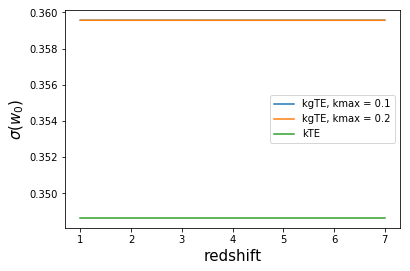

0.348642370307132 0.3595632642754594 0.35956145457890193


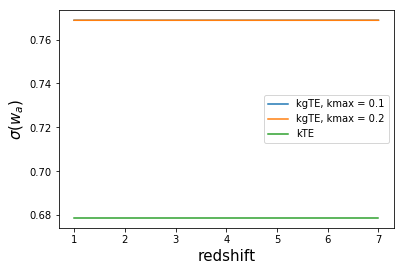

0.6787230942479391 0.7687925957035951 0.7687686765668499


In [57]:
# make the plots
#print nSigmas
doTE = True
#doTE = False

redshifts = [1,2,3,4,7] # top end of each bin; bin1 not included
if doTE:
    plt.plot(redshifts,sigmas_w0_2_01,label='kgTE, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,sigmas_w0_2_02,label='kgTE, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas)*sigmas_kTE2[w0Ind],label='kTE')
else:
    plt.plot(redshifts,sigmas_w0_2_01,label='kg, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,sigmas_w0_2_02,label='kg, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas)*sigmas_kk2[w0Ind],label='kk')
plt.legend()
plt.xlabel('redshift',fontsize=15)
plt.ylabel(r'$\sigma(w_0)$',fontsize=15)
plt.show()
if doTE:
    print sigmas_kTE2[w0Ind], sigmas_w0_2_01[-1], sigmas_w0_2_02[-1]
else:
    print sigmas_kk2[w0Ind], sigmas_w0_2_01[-1], sigmas_w0_2_02[-1]

if doTE:
    plt.plot(redshifts,sigmas_wa_2_01,label='kgTE, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,sigmas_wa_2_02,label='kgTE, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas)*sigmas_kTE2[waInd],label='kTE')
else:
    plt.plot(redshifts,sigmas_wa_2_01,label='kg, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,sigmas_wa_2_02,label='kg, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas)*sigmas_kk2[waInd],label='kk')
plt.legend()
plt.xlabel('redshift',fontsize=15)
plt.ylabel(r'$\sigma(w_a)$',fontsize=15)
plt.show()
if doTE:
    print sigmas_kTE2[waInd], sigmas_wa_2_01[-1], sigmas_wa_2_02[-1]
else:
    print sigmas_kk2[waInd], sigmas_wa_2_01[-1], sigmas_wa_2_02[-1]

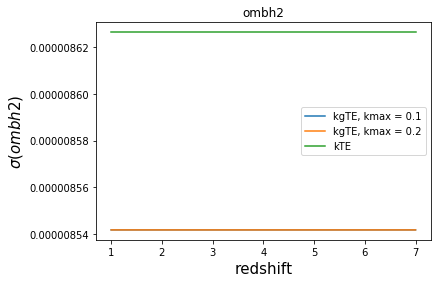

8.626446808587667e-06 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


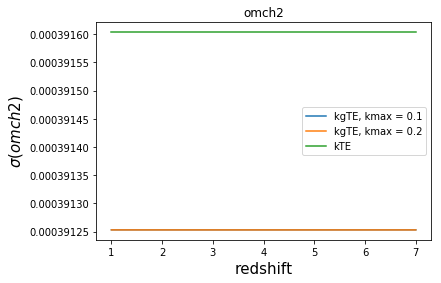

0.00039160352730772935 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


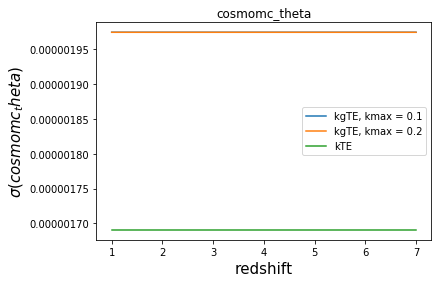

1.6905239854137926e-06 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


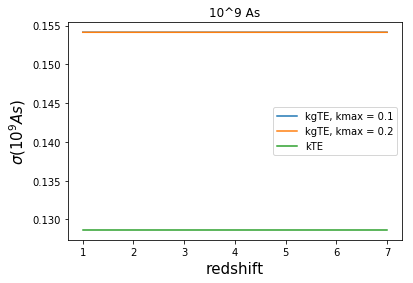

0.12865117007069604 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


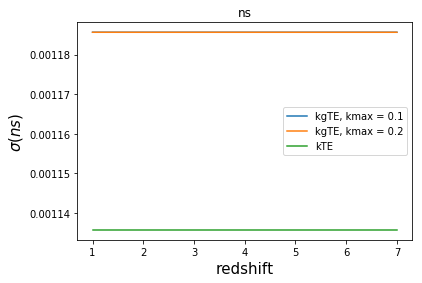

0.001135744540286982 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


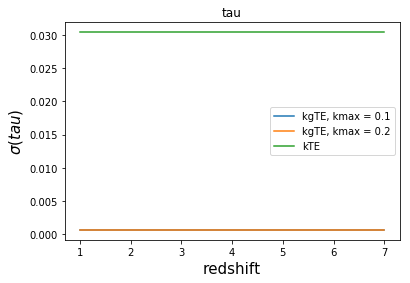

0.030417298741240786 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


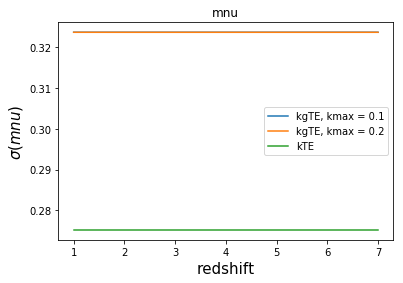

0.27515919565008734 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


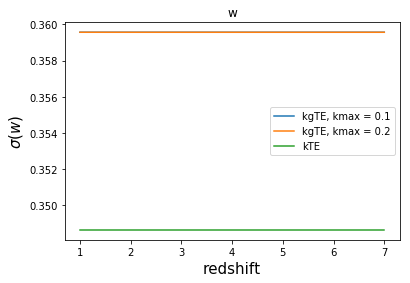

0.348642370307132 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


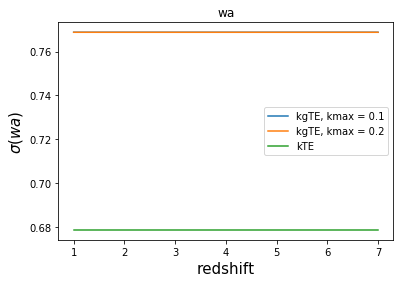

0.6787230942479391 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


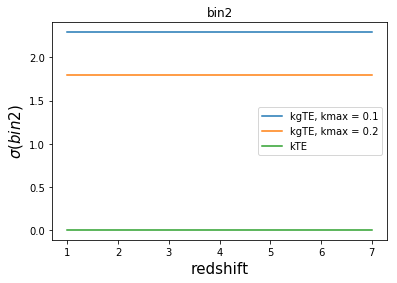

0.0 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


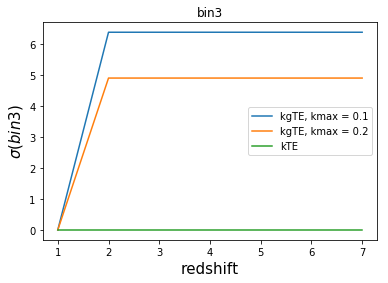

0.0 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


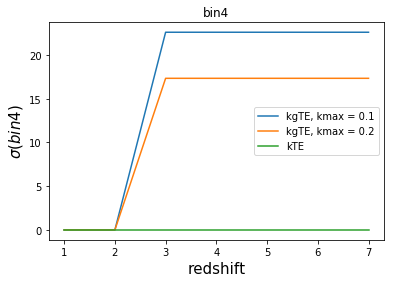

0.0 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


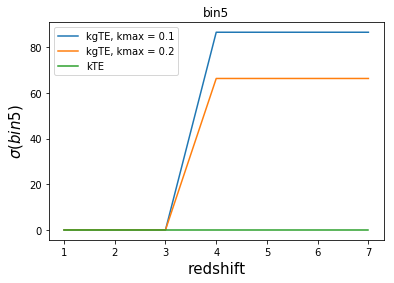

0.0 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


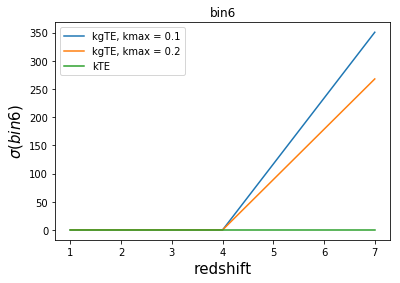

0.0 [8.54172685e-06 3.91253236e-04 1.97452529e-06 1.54144669e-01
 1.18565280e-03 6.58818289e-04 3.23743027e-01 3.59563264e-01
 7.68792596e-01 2.29262458e+00 6.38945275e+00 2.25974605e+01
 8.65860855e+01 3.50639549e+02] [8.54171614e-06 3.91253059e-04 1.97443975e-06 1.54136639e-01
 1.18564287e-03 6.58816951e-04 3.23728340e-01 3.59561455e-01
 7.68768677e-01 1.79451852e+00 4.90854518e+00 1.73313598e+01
 6.63342268e+01 2.67821509e+02]


In [58]:
# make the plots - all of the sigmas this time
redshifts = [1,2,3,4,7] # top end of each bin; bin1 not included
for sigmaNum, paramName in enumerate(paramList2_01):
    if doTE:
        plt.plot(redshifts,np.array(sigmaBins2_01)[:,sigmaNum],label='kgTE, kmax = {0}'.format(kmax1))
        plt.plot(redshifts,np.array(sigmaBins2_02)[:,sigmaNum],label='kgTE, kmax = {0}'.format(kmax2))
        plt.plot(redshifts,np.ones(nSigmas)*sigmas_kTE2[sigmaNum],label='kTE')
    else:
        plt.plot(redshifts,np.array(sigmaBins2_01)[:,sigmaNum],label='kTE, kmax = {0}'.format(kmax1))
        plt.plot(redshifts,np.array(sigmaBins2_02)[:,sigmaNum],label='kTE, kmax = {0}'.format(kmax2))
        plt.plot(redshifts,np.ones(nSigmas)*sigmas_kk2[sigmaNum],label='kk')
    plt.legend()
    plt.xlabel('redshift',fontsize=15)
    plt.ylabel(r'$\sigma({0})$'.format(paramName),fontsize=15)
    plt.title(paramName)
    plt.show()
    if doTE:
        print sigmas_kTE2[sigmaNum], sigmaBins2_01[:][-1], sigmaBins2_02[:][-1]
    else:
        print 'kk: ',sigmas_kk2[sigmaNum],', kmax1:', sigmaBins2_01[-1,sigmaNum],', kmax2:', sigmaBins2_02[-1,sigmaNum]


6.676468776592026


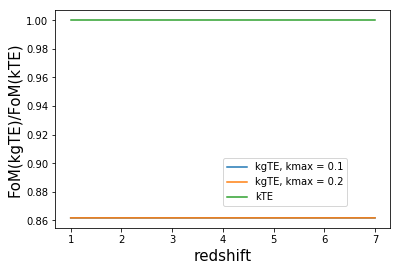

0.8617754114019257 0.8618126724023607


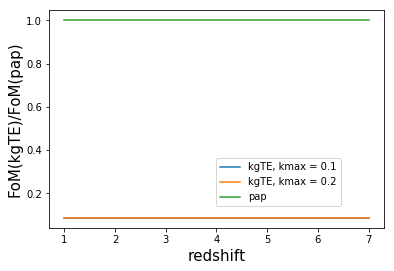

0.08630424939989556 0.0863079809784854


In [59]:
# figure of merit too!

FijInv = np.linalg.inv(Fij_kTE2)
FoMProp_kTE2 = FoMprop(FijInv,iw0=8,iwa=7)
FoMProp_kk = FoMprop(np.linalg.inv(Fij_kk2),iw0=8,iwa=7)
if doTE:
    print FoMProp_kTE2

    plt.plot(redshifts,FoMPropBins2_01/FoMProp_kTE2,label='kgTE, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,FoMPropBins2_02/FoMProp_kTE2,label='kgTE, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas),label='kTE')
    plt.ylabel('FoM(kgTE)/FoM(kTE)',fontsize=15)
else:
    print FoMProp_kk

    plt.plot(redshifts,FoMPropBins2_01/FoMProp_kk,label='kg, kmax = {0}'.format(kmax1))
    plt.plot(redshifts,FoMPropBins2_02/FoMProp_kk,label='kg, kmax = {0}'.format(kmax2))
    plt.plot(redshifts,np.ones(nSigmas),label='k')
    plt.ylabel('FoM(kg)/FoM(k)',fontsize=15)
plt.legend(loc=(0.5,0.1))
plt.xlabel('redshift',fontsize=15)

#plt.ylim((0,0.1))
plt.show()
print FoMPropBins2_01[-1]/FoMProp_kTE2, FoMPropBins2_02[-1]/FoMProp_kTE2

#FoM prop from a paper
FoMProp_pap = 1/0.015

plt.plot(redshifts,FoMPropBins2_01/(np.ones(nSigmas)*FoMProp_pap),label='kgTE, kmax = {0}'.format(kmax1))
plt.plot(redshifts,FoMPropBins2_02/(np.ones(nSigmas)*FoMProp_pap),label='kgTE, kmax = {0}'.format(kmax2))
plt.plot(redshifts,np.ones(nSigmas),label='pap')
plt.legend(loc=(0.5,0.1))
plt.xlabel('redshift',fontsize=15)
plt.ylabel('FoM(kgTE)/FoM(pap)',fontsize=15)
#plt.ylim((0,0.0001))
plt.show()
print FoMPropBins2_01[-1]/FoMProp_pap, FoMPropBins2_02[-1]/FoMProp_pap